# Load neccessary libraries

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import time
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import db_utils as dbu 

# Initiate database connection

In [2]:
dbname    = 'mapd'
username  = 'mapd'
password  = 'HyperInteractive'
hostname  = 'localhost'
port      = 9091

client = dbu.get_client(hostname, port, False)
session = client.connect(username, password, dbname)


# Get data into the GPU

It is expected the table `churn_telco_data` be in the database.
If not the run the following code:
```bash
!~/scripts/create_churn_table.sh
```

In [3]:
table_churn = "churn_telco_data"
query_churn = "SELECT * FROM {} ;".format(table_churn)
print('Query is : ' + query_churn)

tdf = client.sql_execute_gdf(session, query_churn, device_id=0, first_n=-1)

Query is : SELECT * FROM churn_telco_data ;


In [4]:
from pymapd._parsers import _parse_tdf_gpu
gdf = _parse_tdf_gpu(tdf)

Unfortunately at the moment it is not possible to use directly GPU dataframe for xgboost.

In [5]:
pd_df = gdf.to_pandas()
pd_df.head(5)

,State,AccountLength,AreaCode,Phone,IntlPlan,VMailPlan,VMailMessage,DayMins,DayCalls,DayCharge,...,EveCalls,EveCharge,NightMins,NightCalls,NightCharge,IntlMins,IntlCalls,IntlCharge,CustServCalls,Churn
0,CO,77,408,393-7984,no,no,0,62.400002,89,10.610000,...,121,14.440000,209.600006,64,9.43,5.7,6,1.54,5,True.
1,NY,39,408,356-1889,no,no,0,160.399994,68,27.270000,...,103,8.720000,235.300003,106,10.59,9.1,5,2.46,2,False.
2,LA,81,415,392-2722,no,yes,36,115.900002,120,19.700001,...,95,20.110001,255.000000,90,11.48,11.7,6,3.16,3,False.
3,AZ,130,415,358-1958,no,no,0,183.000000,112,31.110001,...,99,6.200000,181.800003,78,8.18,9.5,19,2.57,0,False.
4,FL,124,415,397-1649,no,yes,28,251.399994,104,42.740002,...,89,19.129999,251.899994,121,11.34,7.5,5,2.03,1,False.


# Prepare data for xgboost
String columns have to be converted to numeric.


In [6]:

col_encoders = {}
for col in pd_df.columns[pd_df.dtypes == 'category']:
    label_encoder = LabelEncoder()
    col_encoders[col] = label_encoder.fit(pd_df[col])
    pd_df[col] = col_encoders[col].transform(pd_df[col])
    
pd_df.head(5)

,State,AccountLength,AreaCode,Phone,IntlPlan,VMailPlan,VMailMessage,DayMins,DayCalls,DayCharge,...,EveCalls,EveCharge,NightMins,NightCalls,NightCharge,IntlMins,IntlCalls,IntlCharge,CustServCalls,Churn
0,5,77,408,2327,0,0,0,62.400002,89,10.610000,...,121,14.440000,209.600006,64,9.43,5.7,6,1.54,5,1
1,34,39,408,1054,0,0,0,160.399994,68,27.270000,...,103,8.720000,235.300003,106,10.59,9.1,5,2.46,2,0
2,18,81,415,2270,0,1,36,115.900002,120,19.700001,...,95,20.110001,255.000000,90,11.48,11.7,6,3.16,3,0
3,3,130,415,1119,0,0,0,183.000000,112,31.110001,...,99,6.200000,181.800003,78,8.18,9.5,19,2.57,0,0
4,9,124,415,2442,0,1,28,251.399994,104,42.740002,...,89,19.129999,251.899994,121,11.34,7.5,5,2.03,1,0


## Remove unnecessary columns


In [7]:
y = pd_df['Churn'].values
del pd_df['Churn']
del pd_df['Phone']
#X = pd_df.values

# XGBoost

## Hyper-paramets

In [8]:
param = {}
param['objective'] = 'binary:logistic'
param['eval_metric'] = 'auc'
param['max_depth'] = 5
param['eta'] = 0.3
param['silent'] = 0
param['tree_method'] = 'gpu_exact'

num_round = 20

skf = StratifiedKFold(n_splits=5)

## Train

In [9]:
for i, (train, test) in enumerate(skf.split(pd_df, y)):
    dtrain = xgb.DMatrix(pd_df.iloc[train,:], label=y[train])
    tmp = time.time()
    bst = xgb.train(param, dtrain, num_round)
    boost_time = time.time() - tmp
    res = bst.eval(xgb.DMatrix(pd_df.iloc[test,:], label=y[test]))
    print("Fold {}: {}, Boost Time {}".format(i, res, str(boost_time)))
    #del bst

Fold 0: [0]	eval-auc:0.987997, Boost Time 0.1283254623413086
Fold 1: [0]	eval-auc:0.982771, Boost Time 0.10905003547668457
Fold 2: [0]	eval-auc:0.980881, Boost Time 0.1120908260345459
Fold 3: [0]	eval-auc:0.991792, Boost Time 0.10656881332397461
Fold 4: [0]	eval-auc:0.981953, Boost Time 0.10479187965393066


## Variable Importance

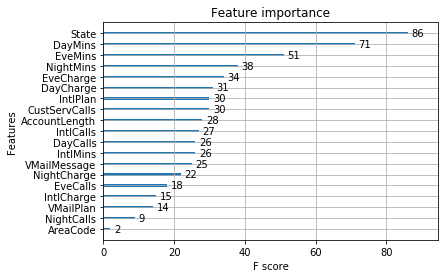

In [10]:
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(bst)
pyplot.show()

### Select top variable importance for grid creation

In [11]:
import operator
num_var = 4
varimp_dict = bst.get_fscore()
varimp = pd.DataFrame(sorted(varimp_dict.items(), key=operator.itemgetter(1), reverse=True))
varimp = varimp.iloc[0:num_var,]
varimp

,0,1
0,State,86
1,DayMins,71
2,EveMins,51
3,NightMins,38


In [12]:

iterCol = 'State' # iterCol is used to break the data into chunks (in case data does not fit in memory)
gridCols = varimp[0].tolist()
excols = list(set(pd_df.columns) - set(gridCols))
gridCols = list(set(gridCols) - set([iterCol]))

print("iterate column:", iterCol)
print("grid columns:", gridCols)
print("excluded columns:", excols)

iterate column: State
grid columns: ['DayMins', 'NightMins', 'EveMins']
excluded columns: ['IntlMins', 'VMailPlan', 'VMailMessage', 'EveCalls', 'IntlCharge', 'NightCharge', 'EveCharge', 'CustServCalls', 'NightCalls', 'IntlPlan', 'AreaCode', 'AccountLength', 'DayCalls', 'DayCharge', 'IntlCalls']


### Create partial dependence grid

In [13]:
from sklearn.ensemble.partial_dependence import _grid_from_X

resolution = 20
df_grid = pd.DataFrame(_grid_from_X(pd_df[gridCols].values, grid_resolution=20)[0], columns=gridCols)
for col in excols:
    df_grid[col] = np.random.choice(pd_df[col].values, size=df_grid.shape[0], replace=True)

print("grid shape:", df_grid.shape)
df_grid.head(5)

grid shape: (8000, 18)


,DayMins,NightMins,EveMins,IntlMins,VMailPlan,VMailMessage,EveCalls,IntlCharge,NightCharge,EveCharge,CustServCalls,NightCalls,IntlPlan,AreaCode,AccountLength,DayCalls,DayCharge,IntlCalls
0,89.800003,118.0,118.800003,5.1,0,0,78,3.27,6.68,14.080000,2,92,0,408,115,120,37.400002,4
1,89.800003,118.0,127.510529,10.9,1,37,104,2.65,4.54,20.719999,1,78,0,415,92,115,29.219999,4
2,89.800003,118.0,136.221054,8.5,0,0,92,3.97,6.47,20.660000,4,99,0,415,111,97,24.450001,3
3,89.800003,118.0,144.931580,12.2,1,0,127,2.48,6.04,22.580000,1,125,0,415,84,88,32.540001,4
4,89.800003,118.0,153.642105,8.7,0,31,122,2.54,5.36,21.600000,4,106,0,510,113,75,39.759998,1


### Calculate partial dependence predictions and save the results

In [15]:
!mkdir -p ./res

In [16]:
fmt=['%.3f', '%.3f', '%.3f', '%.3f', '%.3f', '%i', '%i', '%i', '%i', 
     '%i', '%.3f', '%i', '%i', '%i', '%.3f', '%.3f', '%.3f', '%i', '%i', '%s']

iterVals = pd_df[iterCol].unique()
bst.set_param({"predictor":"cpu_predictor"})
for v in iterVals:   
    t0 = time.time()
    print("State: ", v)
    
    # Set all state value to v
    df_grid[iterCol] = v
    t1 = time.time()
    
    #Predict
    pred_p1 = bst.predict(xgb.DMatrix(df_grid[pd_df.columns]))
    t2 = time.time()
    print("Time to pred: ", (t2-t1))
    
    #Concat prediction probs with predictors
    tmp_df = pd.concat([pd.DataFrame(pred_p1, columns=["p1"]), df_grid], axis=1)
    t3 = time.time()
    print("Time to concat: ", (t3-t2))
    
    # Decode state values
    tmp_df['State'] = col_encoders['State'].inverse_transform(tmp_df['State'])
    t4 = time.time()
    print("Time to encode state col: ", (t4-t3))
    
    # Save results
    fname = './res/df_state-{}.csv'.format(col_encoders['State'].inverse_transform(v))
    np.savetxt(fname, tmp_df.values, fmt=fmt, delimiter=',')
    t5 = time.time()
    print("Time to save results: ", (t5-t4))
    
    print("Time to loop:", (t5-t0))

State:  5
Time to pred:  0.015015840530395508
Time to concat:  0.004130125045776367
Time to encode state col:  0.0011358261108398438
Time to save results:  0.06680154800415039
Time to loop: 0.08795595169067383
State:  34
Time to pred:  0.006807088851928711
Time to concat:  0.002854585647583008
Time to encode state col:  0.0012366771697998047
Time to save results:  0.0663301944732666
Time to loop: 0.0779571533203125
State:  18
Time to pred:  0.005174160003662109
Time to concat:  0.004578113555908203
Time to encode state col:  0.0010361671447753906
Time to save results:  0.06888628005981445
Time to loop: 0.08057904243469238
State:  3
Time to pred:  0.0051822662353515625
Time to concat:  0.0033326148986816406
Time to encode state col:  0.0011527538299560547
Time to save results:  0.06724929809570312
Time to loop: 0.07758641242980957
State:  9
Time to pred:  0.00519871711730957
Time to concat:  0.003244161605834961
Time to encode state col:  0.0010366439819335938
Time to save results:  0.0

Time to save results:  0.06672453880310059
Time to loop: 0.07678747177124023
State:  10
Time to pred:  0.005115985870361328
Time to concat:  0.003087759017944336
Time to encode state col:  0.0009765625
Time to save results:  0.06515860557556152
Time to loop: 0.07523393630981445
State:  8
Time to pred:  0.005112886428833008
Time to concat:  0.003047943115234375
Time to encode state col:  0.0009388923645019531
Time to save results:  0.06519365310668945
Time to loop: 0.07499003410339355
State:  12
Time to pred:  0.00510716438293457
Time to concat:  0.0029778480529785156
Time to encode state col:  0.0009257793426513672
Time to save results:  0.06586360931396484
Time to loop: 0.07554054260253906
State:  42
Time to pred:  0.005112648010253906
Time to concat:  0.0030083656311035156
Time to encode state col:  0.0009500980377197266
Time to save results:  0.06560897827148438
Time to loop: 0.07536959648132324
State:  21
Time to pred:  0.005107879638671875
Time to concat:  0.0029821395874023438
Ti

## Load the result into MapD database 

#### Create table for the results.

In [92]:
result_table_name = "churn_pd_results"
dbu.create_table_for(session, client, tmp_df, result_table_name)

Create query:  create table churn_pd_results ( p1 FLOAT, EveMins FLOAT, DayMins FLOAT, DayCharge FLOAT, VMailPlan INT, NightCalls INT, IntlCalls INT, CustServCalls INT, DayCalls INT, EveCharge FLOAT, EveCalls INT, IntlPlan INT, AccountLength INT, NightCharge FLOAT, IntlMins FLOAT, IntlCharge FLOAT, AreaCode INT, NightMins FLOAT, VMailMessage INT, State TEXT ); 


TQueryResult(nonce='', total_time_ms=20, execution_time_ms=11, row_set=TRowSet(rows=[], columns=[], row_desc=[], is_columnar=False))

#### Copy csv files into table:

In [107]:
wd = !pwd
copy_q = "COPY {} FROM '{}';".format(result_table_name, wd[0]+"/res/*")
client.sql_execute(session, copy_q, True, None, -1)

TQueryResult(nonce='', total_time_ms=3106, execution_time_ms=3098, row_set=TRowSet(rows=[], columns=[TColumn(data=TColumnData(int_col=[], str_col=['Loaded: 407949 recs, Rejected: 0 recs in 3.029000 secs'], arr_col=[], real_col=[]), nulls=[False])], row_desc=[TColumnType(is_reserved_keyword=False, col_name='Result', src_name='', col_type=TTypeInfo(is_array=False, comp_param=0, nullable=False, encoding=0, scale=0, precision=0, type=6))], is_columnar=True))